# Домашнее задание
- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML
## Модели ARIMA и GARCH

In [ ]:
!pip install arch

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm
from arch import arch_model
from sklearn.linear_model import LinearRegression
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## Проведем анализ для monthly-sales-of-company-x-jan-6.

Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


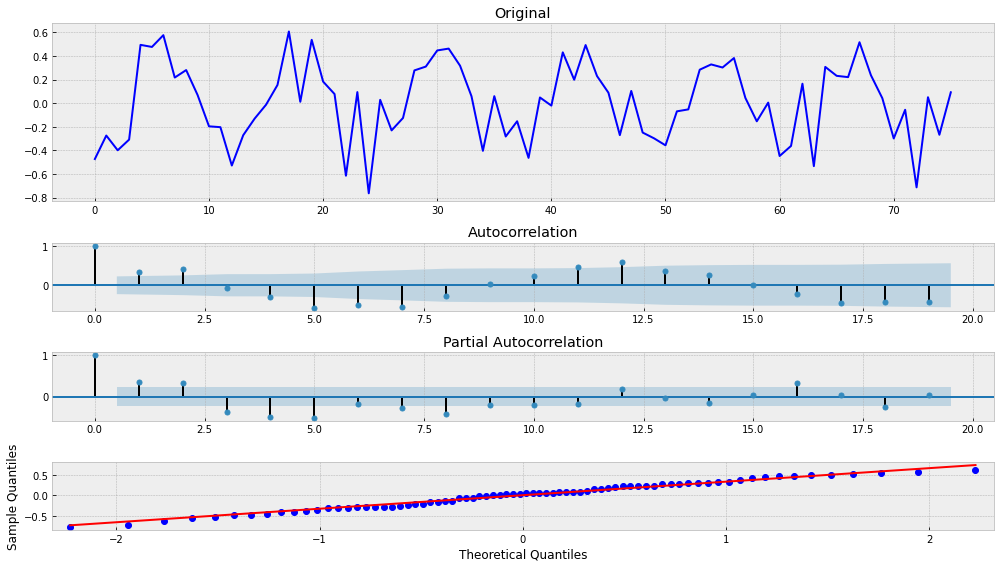

In [5]:
series = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")["Count"].values.astype('float64')
series_bc = boxcox(series, 0)
series_bc_diff = series_bc[1:] - series_bc[:-1]
tsplot(series_bc_diff)

In [6]:
len(series_bc_diff)

76

## ARIMA

In [7]:
train, val = series_bc_diff[:46], series_bc_diff[46:]

aic: -1.98953 | order: (2, 0, 2)
Results of Dickey-Fuller Test:
Test Statistic                -1.115001e+01
p-value                        2.959910e-20
#Lags Used                     0.000000e+00
Number of Observations Used    4.500000e+01
Critical Value (1%)           -3.584829e+00
Critical Value (5%)           -2.928299e+00
Critical Value (10%)          -2.602344e+00
dtype: float64


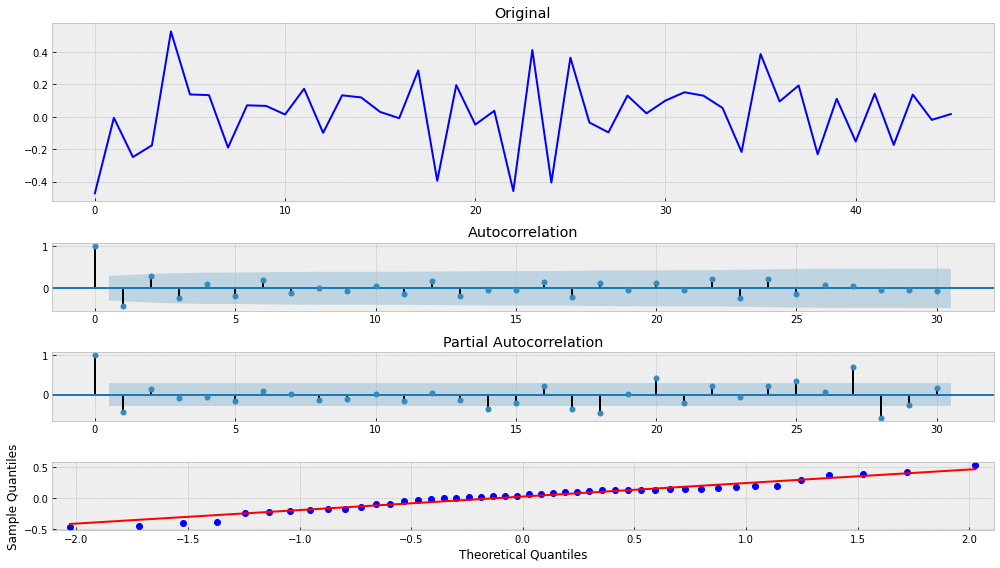

In [8]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(train, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

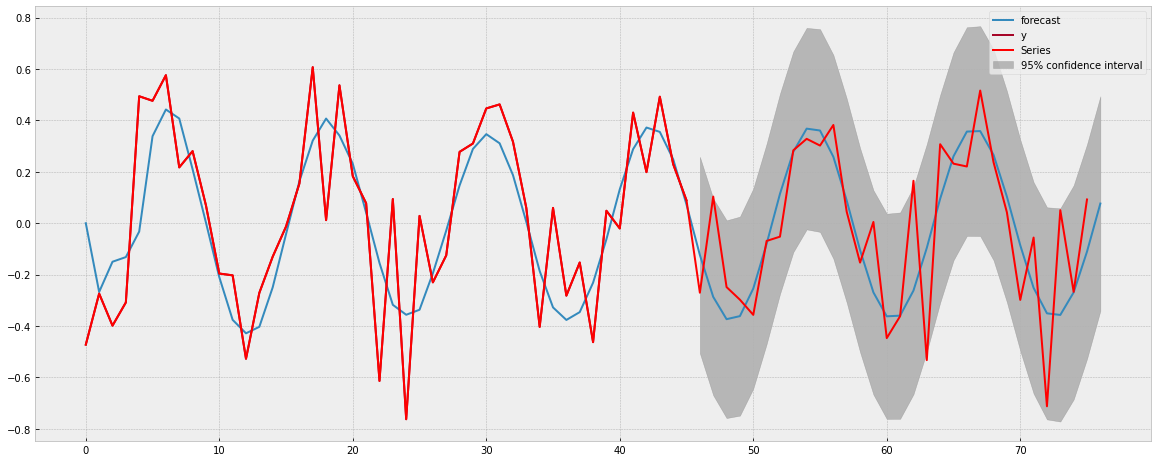

In [9]:
with plt.style.context('bmh'):
    plt.figure(figsize=(20,8))
    ax = plt.axes()
    best_mdl.plot_predict(0, len(series_bc_diff), ax=ax)
    plt.plot(series_bc_diff, color='red', label='Series')
    plt.legend()
    plt.show()

## GARCH

In [10]:
from tqdm import tqdm_notebook as tqdm
from arch import arch_model

In [11]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(train, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.002
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                            GARCH   Log-Likelihood:               -15.0185
Distribution:      Standardized Student's t   AIC:                           44.0371
Method:                  Maximum Likelihood   BIC:                           56.8376
                                              No. Observations:                   46
Date:                      Wed, Aug 12 2020   Df Residuals:                       39
Time:                              23:01:25   Df Model:                            7
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

Results of Dickey-Fuller Test:
Test Statistic                -6.321204e+00
p-value                        3.063043e-08
#Lags Used                     7.000000e+00
Number of Observations Used    3.800000e+01
Critical Value (1%)           -3.615509e+00
Critical Value (5%)           -2.941262e+00
Critical Value (10%)          -2.609200e+00
dtype: float64


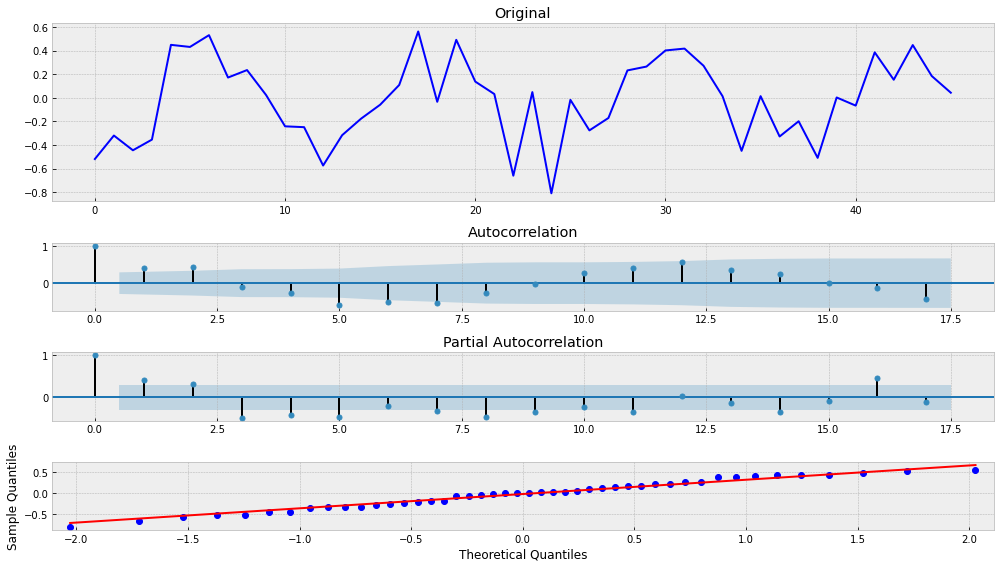

In [12]:
tsplot(res.resid)

In [13]:
pred = res.forecast(horizon=len(val), method='simulation', simulations=1000)

In [14]:
forecast = train.copy()
forecast = np.concatenate((forecast, pred.variance.values[-1, :]))

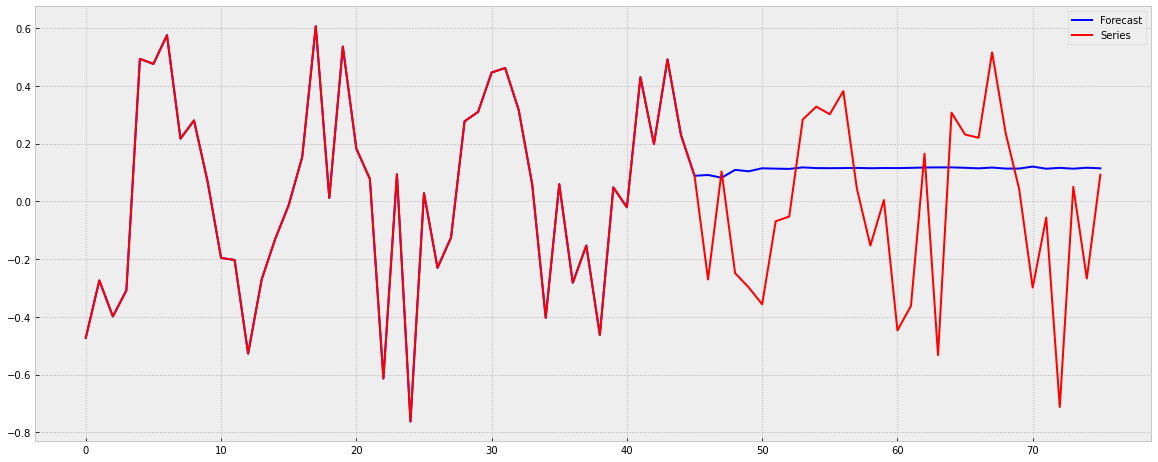

In [15]:
with plt.style.context('bmh'):
    plt.figure(figsize=(20,8))
    ax = plt.axes()
    plt.plot(forecast, color='blue', label='Forecast')
    plt.plot(series_bc_diff, color='red', label='Series')
    plt.legend()
    plt.show()

### Прогноз классическим ML

In [22]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ["Count"]
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data["Count"].shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [23]:
X_train, X_test, y_train, y_test = prepareData(series_, lag_start=1, lag_end=20, test_size=0.3)

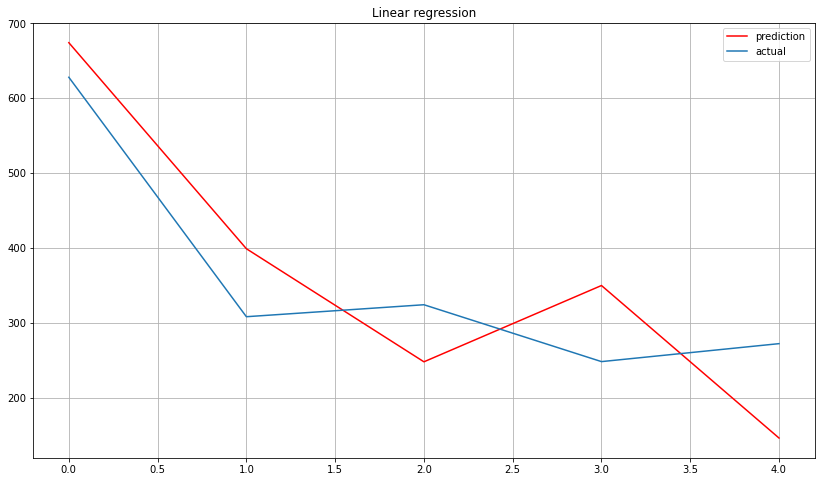

In [24]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);